In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn

from functools import partial
from sklearn import datasets

In [2]:
iris = datasets.load_iris(as_frame=True)

In [3]:
iris["data"].head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [4]:
sepal_width = iris.data["sepal width (cm)"].values

In [23]:
distribution = "johnsonsu"
match distribution.lower():
    case "johnsonsu":
        dist = scipy.stats.johnsonsu
        cons = [
            {'type': 'ineq', 'fun': lambda x: x[1] + 1e-5},
            {'type': 'ineq', 'fun': lambda x: x[3] + 1e-5},
        ]
    case "weibull":
        dist = scipy.stats.weibull_min
        cons = []
    case _:
        dist = scipy.stats.norm
        cons = []

In [24]:
def ll(data, params):
    return np.sum(dist.logpdf(data, *params))

def nll(data, params):
    return -1 * ll(data, params)

In [25]:
sol = scipy.optimize.minimize(partial(nll, sepal_width), x0=[0, 1, 0, 1], method="SLSQP", constraints=cons)
sol

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 86.56001272002162
       x: [-2.995e+00  5.097e+00  1.891e+00  1.840e+00]
     nit: 30
     jac: [ 7.774e-03  1.939e-03 -6.378e-03  1.268e-03]
    nfev: 169
    njev: 30

In [26]:
def calc_ll_target(conf, data, params, sided=1):
    ll_mle = ll(data, params)
    alpha_eff = 2 * (1 - conf) / sided
    print("alpha effective:", alpha_eff)
    chi2val = scipy.stats.chi2.ppf(1 - alpha_eff, df=1)
    ll_target = ll_mle - chi2val / 2
    return ll_target


ll_target = calc_ll_target(0.99, sepal_width, sol.x, sided=1)
ll_target2 = calc_ll_target(0.99, sepal_width, sol.x, sided=2)
ll_target, ll_target2

alpha effective: 0.020000000000000018
alpha effective: 0.010000000000000009


(np.float64(-89.26595993554879), np.float64(-89.87746102053222))

In [27]:
def ll_target_cons(data, ll_target, params):
    return ll_target - ll(data, params)


def obj_upper(coverage, params):
    return -1 * dist.ppf(coverage, *params)


def obj_lower(coverage, params):
    return dist.ppf(coverage, *params)


def obj_double(lower_coverage, upper_coverage, params):
    upper_quantile = dist.ppf(upper_coverage, *params)
    lower_quantile = dist.ppf(lower_coverage, *params)
    return lower_quantile - upper_quantile  # Minimize this <-> maximize interval width, which is upper_quantile - lower_quantile

In [28]:
# 99conf/75converage upper TL
othercons = [{"type": "eq", "fun": partial(ll_target_cons, sepal_width, ll_target)}]

In [29]:
sol_upper = scipy.optimize.minimize(partial(obj_upper, 0.75), x0=sol.x, method="SLSQP", constraints=othercons+cons, options={"maxiter": 2500})
sol_upper, dist.ppf(0.75, *sol_upper.x)

( message: Optimization terminated successfully
  success: True
   status: 0
      fun: -3.4400072193481424
        x: [-8.707e+00  8.317e+00  6.712e-02  2.439e+00]
      nit: 218
      jac: [ 5.005e-01  5.646e-01 -1.000e+00 -1.383e+00]
     nfev: 1508
     njev: 218,
 np.float64(3.4400072193481424))

In [30]:
assert np.isclose(dist.ppf(0.75, *sol_upper.x), 3.4400072193481424)

In [31]:
sol_lower = scipy.optimize.minimize(partial(obj_lower, 0.25), x0=sol.x, method="SLSQP", constraints=othercons+cons, options={"maxiter": 2500})
sol_lower, dist.ppf(0.25, *sol_lower.x)

( message: Optimization terminated successfully
  success: True
   status: 0
      fun: 2.6649803421480187
        x: [-3.165e+01  7.912e+00 -6.302e-01  1.315e-01]
      nit: 576
      jac: [-4.168e-01 -1.632e+00  1.000e+00  2.507e+01]
     nfev: 3351
     njev: 576,
 np.float64(2.6649803421480187))

In [32]:
assert np.isclose(dist.ppf(0.25, *sol_lower.x), 2.6649803421480187)

In [33]:
othercons2 = [{"type": "eq", "fun": partial(ll_target_cons, sepal_width, ll_target2)}]
sol_double = scipy.optimize.minimize(partial(obj_double, 0.25, 0.75), x0=sol.x, constraints=othercons2+cons, options={"maxiter": 2500})

In [34]:
sol_double

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.6818779353652933
       x: [-2.014e+01  7.370e+00 -6.388e-01  4.822e-01]
     nit: 333
     jac: [ 9.174e-02  3.434e-01  0.000e+00 -1.414e+00]
    nfev: 2041
    njev: 333

In [35]:
dist.ppf(0.25, *sol_double.x), dist.ppf(0.75, *sol_double.x)

(np.float64(2.7247188389753085), np.float64(3.406596774340602))

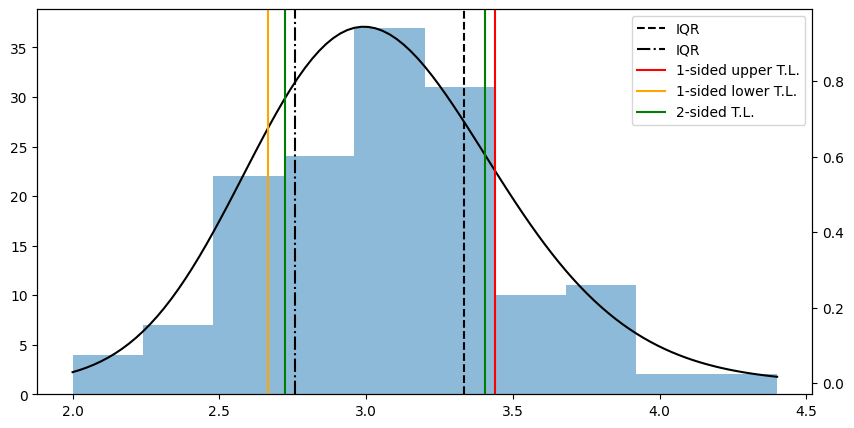

In [36]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

ax1.hist(sepal_width, alpha=0.5)

xarr = np.linspace(sepal_width.min(), sepal_width.max(), 101)
ax2.plot(xarr, dist.pdf(xarr, *sol.x), color="black")
ax2.axvline(dist.ppf(0.75, *sol.x), color="black", linestyle="--", label="IQR")
ax2.axvline(dist.ppf(0.25, *sol.x), color="black", linestyle="-.", label="IQR")

ax2.axvline(dist.ppf(0.75, *sol_upper.x), color="red", label="1-sided upper T.L.")
ax2.axvline(dist.ppf(0.25, *sol_lower.x), color="orange", label="1-sided lower T.L.")

ax2.axvline(dist.ppf(0.75, *sol_double.x), color="green", label="2-sided T.L.")
ax2.axvline(dist.ppf(0.25, *sol_double.x), color="green")

plt.legend()